<a href="https://colab.research.google.com/github/saikiran2711/resnet50_face_recognition/blob/main/Core_Original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mtcnn

In [ ]:
!pip install keras_vggface

In [ ]:
!pip install keras_applications

In [49]:
import keras
from matplotlib import pyplot
from IPython.display import display
from PIL import Image
from numpy import asarray
from scipy.spatial.distance import cosine
from mtcnn.mtcnn import MTCNN
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

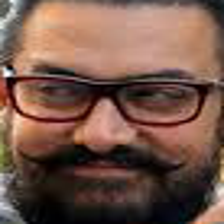

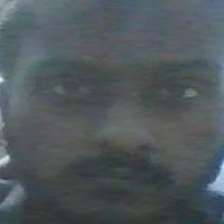

Positive Tests
>face is NOT a Match (0.634 > 0.500)


In [53]:
# face verification with the VGGFace2 model


# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
  # load image from file
  pixels = pyplot.imread(filename)
  # create the detector, using default weights
  detector = MTCNN()
  # detect faces in the image
  results = detector.detect_faces(pixels)
  # extract the bounding box from the first face
  x1, y1, width, height = results[0]['box']
  x2, y2 = x1 + width, y1 + height
  # extract the face
  face = pixels[y1:y2, x1:x2]
  # resize pixels to the model size
  image = Image.fromarray(face)
  image = image.resize(required_size)
  face_array = asarray(image)
  display(Image.fromarray(face_array))
  return face_array

# extract faces and calculate face embeddings for a list of photo files
def get_embeddings(filenames):
  # extract faces
  faces = [extract_face(f) for f in filenames]
  # convert into an array of samples
  samples = asarray(faces, 'float32')
  # prepare the face for the model, e.g. center pixels

  samples = preprocess_input(samples, version=2)
  
  # create a vggface model
  model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
  # perform prediction
  yhat = model.predict(samples)
  return yhat

# determine if a candidate face is a match for a known face
def is_match(known_embedding, candidate_embedding, thresh=0.5):
	# calculate distance between embeddings
	score = cosine(known_embedding, candidate_embedding)
	if score <= thresh:
		print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
	else:
		print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))

# define filenames
filenames = ['/content/amirg.jpg','/content/photo.jpg']
# get embeddings file filenames
embeddings = get_embeddings(filenames)
# define sharon stone
sachin = embeddings[0]
sachint= embeddings[1]
# verify known photos of sharon
print('Positive Tests')
is_match(sachin, sachint)

In [46]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))